<a href="https://colab.research.google.com/github/lsellers11/Black-Holes/blob/main/minkbtimestepRandI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

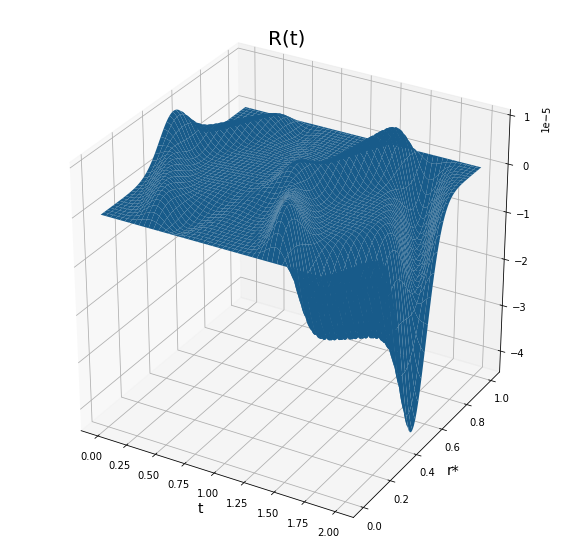

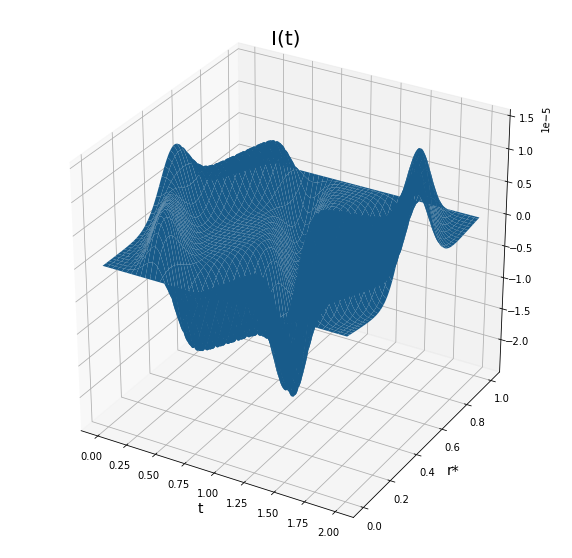

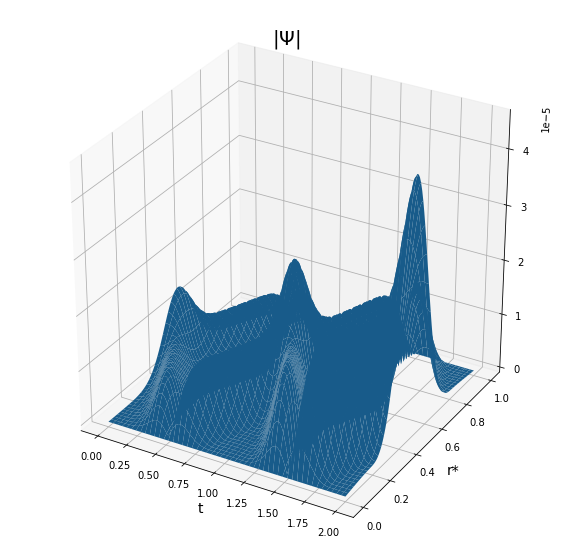

In [ ]:
import numpy as np
from sympy import *
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy import integrate as scint
import scipy.optimize as scopt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
from timeit import default_timer as timer
from random import randint

### Grid Parameters
Nt = 300;
Nr = 100;
Lt = 2;
Lr = 1;

tgrid, dt = np.linspace(0, Lt, Nt, retstep=True);
rgrid, dr = np.linspace(0, Lr, Nr, retstep=True);

### Physical Parameters

# Orbital 
m = 1;
w = 1;

# Higgs Pot
lamb = 1;
v2 = .5;

# b^mu
bt = 1.2;
br = 0;
bphi = 0;

### Finite Differences
def Dt2(Rk1n0, Rk0n0, R1kn0): 
  return (Rk1n0 - 2*Rk0n0 + R1kn0) / dt**2;

def Dr2(Rk0n1, Rk0n0, Rk01n):
  return (Rk0n1 - 2*Rk0n0 + Rk01n) / dr**2;

def Dt(Rk1n0, R1kn0):
  return (Rk1n0 - R1kn0) / (2*dt);

def Dr(Rk0n1, Rk01n):
  return (Rk0n1 - Rk01n) / (2*dr);

### Coupled PDEs
def geteqs(Rk0n0, R1kn0, Rk0n1, Rk01n, Ik0n0, I1kn0, Ik0n1, Ik01n, r):
  def equations(p):
    x,y = p;

    def F(x,y): # Real Part of PDE

      return -1*Dt2(x, Rk0n0, R1kn0) + Dr2(Rk0n1, Rk0n0, Rk01n) + bt*Dt(x, R1kn0) - 2*w*Dt(y, I1kn0) + (1/r + br)*Dr(Rk0n1, Rk01n) + (w**2 - m**2/r**2)*Rk0n0 - m*bphi*Ik0n0 - lamb/2*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0;

    def G(x,y): # Imaginary Part of PDE

      return -1*Dt2(y, Ik0n0, I1kn0) + Dr2(Ik0n1, Ik0n0, Ik01n) + bt*Dt(y, I1kn0) + 2*w*Dt(x, R1kn0) + (1/r + br)*Dr(Ik0n1, Ik01n) + (w**2 - m**2/r**2)*Ik0n0 + m*bphi*Rk0n0 - lamb/2*((Rk0n0**2 + Ik0n0**2) - v2)*Ik0n0;

    return (F(x,y), G(x,y));

  return equations;

### Initialize
R = np.zeros((Nr, Nt));
I = np.zeros((Nr, Nt));

### Initial Conditions

## R(r,0) & I(r,0)

# For Pulse Test
amp = 1e-5;
sigma = dr;
p0 = int(Nr/2) - 1;

# Profiles
def fR(x):
  return amp*np.exp((-1*(x-rgrid[p0])**2) / (2*sigma)); # Pulse Test

def fI(x):
  return amp*np.exp((-1*(x-rgrid[p0])**2) / (2*sigma)); # Pulse Test

R[:, 0] = fR(rgrid);
I[:, 0] = fI(rgrid);

## d/dt R(r,0) & I(r,0)
def gR(x):
  return 0; # Pulse Test

def gI(x):
  return 0;

## Solve for 1st 2 Rows

# Boundary Conditions
R0t = 0;
RLrt = 0;
I0t = 0;
ILrt = 0;

R[0, :] = R0t;
R[Nr-1, :] = RLrt;
I[0, :] = I0t;
I[Nr-1, :] = ILrt;

# Functions for Initial Conditions
def geteqs0(Rk0n0, Ik0n0, Rk0n1, Rk01n, Ik0n1, Ik01n, r):
  def equations(p):
    x,y = p;

    def F(x,y):
      return -1*Dt2(x, Rk0n0, x-2*dt*gR(r)) + Dr2(Rk0n1, Rk0n0, Rk01n) + bt*Dt(x, x-2*dt*gR(r)) - 2*w*Dt(y, y - 2*dt*gI(r)) + (1/r + br)*Dr(Rk0n1, Rk01n) + (w**2 - m**2/r**2)*Rk0n0 - m*bphi*Ik0n0 - lamb/2*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0;

    def G(x,y):
      return -1*Dt2(y, Ik0n0, y - 2*dt*gI(r)) + Dr2(Ik0n1, Ik0n0, Ik01n) + bt*Dt(y, y - 2*dt*gI(r)) + 2*w*Dt(x, x - 2*dt*gR(r)) + (1/r + br)*Dr(Ik0n1, Ik01n) + (w**2 - m**2/r**2)*Ik0n0 + m*bphi*Rk0n0 - lamb/2*((Rk0n0**2 + Ik0n0**2) - v2)*Ik0n0;

    return (F(x,y), G(x,y));

  return equations;

## Solve for R and I after 1st Time Step
i = 0;
for j in range(1, Nr-1):
  r = j*dr + 1.0;
  Rk0n0 = R[j, i];
  Rk0n1 = R[j+1, i];
  Rk01n = R[j-1, i];

  Ik0n0 = I[j, i];
  Ik0n1 = I[j+1, i];
  Ik01n = I[j-1, i];

  eqs = geteqs0(Rk0n0, Ik0n0, Rk0n1, Rk01n, Ik0n1, Ik01n, r);

  R[j, i+1], I[j, i+1] = scopt.fsolve(eqs, (R[j, i], I[j, i]));

# ## Plot Test Initial Profile
# Rs, T = np.meshgrid(tgrid, rgrid);
# fig1 = plt.figure(figsize=(10,10));
# ax1 = fig1.add_subplot(111, projection = '3d');
# ax1.plot_surface(Rs, T, R);

# fig2 = plt.figure(figsize=(10,10));
# ax2 = fig2.add_subplot(111, projection = '3d');
# ax2.plot_surface(Rs, T, I);

# plt.show()

### Solve for Interior
for i in range(1, Nt-1):
  for j in range(1, Nr-1):
    r = j*dr + 1.0;

    R1kn0 = R[j, i-1];
    Rk0n0 = R[j, i];
    Rk0n1 = R[j+1, i];
    Rk01n = R[j-1, i];

    I1kn0 = I[j, i-1];
    Ik0n0 = I[j, i];
    Ik0n1 = I[j+1, i];
    Ik01n = I[j-1, i];

    eqs = geteqs(Rk0n0, R1kn0, Rk0n1, Rk01n, Ik0n0, I1kn0, Ik0n1, Ik01n, r);
    R[j, i+1], I[j, i+1] = scopt.fsolve(eqs, (Rk0n0, Ik0n0));

### Plots

## R(t)
Rs, T = np.meshgrid(tgrid, rgrid);
fig1 = plt.figure(figsize=(10,10));
ax1 = fig1.add_subplot(111, projection = '3d');
ax1.set_xlabel('t', fontsize = 14.0);
ax1.set_ylabel('r*', fontsize = 14.0);
ax1.set_title('R(t)', fontsize = 20.0);
ax1.plot_surface(Rs, T, R);

## I(t)
fig2 = plt.figure(figsize=(10,10));
ax2 = fig2.add_subplot(111, projection = '3d');
ax2.set_xlabel('t', fontsize = 14.0);
ax2.set_ylabel('r*', fontsize = 14.0);
ax2.set_title('I(t)', fontsize = 20.0);
ax2.plot_surface(Rs, T, I);

## Calc Norm 
norm2 = np.zeros((Nr, Nt));
for i in range(Nr):
  for j in range(Nt):
    norm2[i, j] = (R[i, j]**2 + I[i, j]**2)**(1/2);

## Norm(t)
fig3 = plt.figure(figsize=(10,10));
ax3 = fig3.add_subplot(111, projection = '3d');
ax3.set_xlabel('t', fontsize = 14.0);
ax3.set_ylabel('r*', fontsize = 14.0);
ax3.set_title('$|\Psi|$', fontsize = 20.0);
ax3.plot_surface(Rs, T, norm2);

# # Turn R, I, and Norm2 into vectors
# Rv = np.zeros(Nr*Nt);
# Iv = np.zeros(Nr*Nt);
# Norm2v = np.zeros(Nr*Nt);
# for k in range(Nr*Nt):
#   i = k%Nr;
#   j = int((k-i)/Nr);
#   Rv[k] = R[i, j];
#   Iv[k] = I[i, j];
#   Norm2v[k] = Norm


plt.show()

